In [ ]:
# KUC, PRG210
#P9

In [1]:
import pandas as pd
import numpy as np


path='abcnews-date-text.csv'
pd.read_csv(path).head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [3]:
newsData = pd.read_csv(path, encoding='ascii')
newsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226258 entries, 0 to 1226257
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   publish_date   1226258 non-null  int64 
 1   headline_text  1226258 non-null  object
dtypes: int64(1), object(1)
memory usage: 18.7+ MB


## First, lets filter our dataset and make a reduced version

In [4]:
newsData.headline_text[:1000]

0      aba decides against community broadcasting lic...
1         act fire witnesses must be aware of defamation
2         a g calls for infrastructure protection summit
3               air nz staff in aust strike for pay rise
4          air nz strike to affect australian travellers
                             ...                        
995                  conference to focus on tuna fishery
996                        council hosts farewell for mp
997                  council resists eba roster pressure
998                     customs house restoration opened
999                dam water levels still critically low
Name: headline_text, Length: 1000, dtype: object

In [5]:
#a mask filters data by defining boolean parameters
mask=np.array([bool(round(item*0.5010))for item in np.random.rand(newsData.shape[0],).tolist()])

newsData_reduced= newsData[mask]

In [6]:
print(len(newsData_reduced))

2433


## Useful libraries for tracking processing progress

In [7]:
from tqdm import tqdm
from tqdm.notebook import trange, tqdm

tqdm.pandas(desc='Preprocessing text')


from nltk import word_tokenize
from nltk.corpus import stopwords
stops=stopwords.words('english')


In [8]:
def preprocessing(corpus):
    out=[word.strip().lower() for word in word_tokenize(corpus) if word not in stops and word.isalnum() ]
    out=' '.join(out)
    return out


### .progress_apply from tqdm same as .apply but with progress bar

In [9]:
newsData_reduced['headline_text'] = newsData_reduced.headline_text.progress_apply(lambda x: preprocessing(x))

Preprocessing text:   0%|          | 0/2433 [00:00<?, ?it/s]

/var/folders/jw/pk9yd5v978d_6j_wky4ptw480000gn/T/ipykernel_53650/1172714680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newsData_reduced['headline_text'] = newsData_reduced.headline_text.progress_apply(lambda x: preprocessing(x))


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
def vectorGenerator(documents_preprocessed):
    from datetime import datetime
    beg = datetime.now()
    
    vectorizer = CountVectorizer() 
    
    bow = vectorizer.fit_transform(documents_preprocessed)  #note that you must use the preprocessed documents in string 
                                                                #form for this function/method
    end = datetime.now()
    
    print('documents processed:',bow.shape[0])
    print('time spent:',end-beg)
    return bow, vectorizer


In [12]:
bow_reduced, bow_vectorizer = vectorGenerator(newsData_reduced['headline_text'])
bow_reduced

documents processed: 2433
time spent: 0:00:00.091134


<2433x5555 sparse matrix of type '<class 'numpy.int64'>'
	with 13051 stored elements in Compressed Sparse Row format>

## Cosine similarity on reduced data

In [13]:
cosine_sim =cosine_similarity(bow_reduced)

#setting all the "self to self comparisons" to zero so they dont show up as the best match

for i in range(cosine_sim.shape[0]):
    cosine_sim[i,i] = 0

# Get the most similar item for random sampled row 

row_idx = np.random.randint(cosine_sim.shape[0])
most_similar = np.argmax(cosine_sim[row_idx])

    
print('Sample headline:')

print(newsData_reduced['headline_text'].iloc[row_idx])
print('\n---------------------------------------\n')
print('The most similar to sample headline:')

newsData_reduced.headline_text.iloc[(most_similar)]

Sample headline:
torres strait islanders battle league cup

---------------------------------------

The most similar to sample headline:


'land battle cape barren islanders'

## Now, lets work with the complete dataframe of 1226258 headlines

In [14]:
import re
from joblib import Parallel, delayed

def preProcessingParallel(document):
    """A function performing all pre-processing steps
    on ONE document"""
    
    
    #removing stopwords and whitespace and punctuation/
    #special characters
    documentNonstop = (' ').join([
            re.sub('[^A-Za-z0-9æøå]','',w.strip()) 
            for w in word_tokenize(document) 
            if not w.strip() in stops and w.isalnum()
                        ])
    
    return documentNonstop

In [15]:
newsData_preprocessed_full = Parallel(n_jobs=-1,verbose=3)(
    delayed(preProcessingParallel)(document) for document in tqdm(newsData.headline_text))

  0%|          | 0/1226258 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 18444 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 434188 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1024012 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 1226258 out of 1226258 | elapsed:   19.0s finished


In [16]:
def TfIdfvectorGenerator(documents_preprocessed):
    """ Taking a corpus of documents which have been preprocessed and exist in string shape, 
    creates TFIDF representations and returns the representations, and the TFIDF vectorizer"""
    from datetime import datetime
    beg = datetime.now()
    vectorizer = TfidfVectorizer(min_df=1,
                                 max_df=0.75) 
    
    tfidf = vectorizer.fit_transform(documents_preprocessed)  #note that you must use the preprocessed documents in string 
                                                                #form for this function/method
    end = datetime.now()
    
    print('documents processed:',tfidf.shape[0])
    print('time spent:',end-beg)
    return tfidf, vectorizer

In [17]:
tfidf, vectorizer = TfIdfvectorGenerator(newsData_preprocessed_full) #The vectorizer from sklearn is already fast (no need for parallel)

documents processed: 1226258
time spent: 0:00:06.104343


In [18]:
row_idx = np.random.randint(newsData.shape[0])

cosineDistances = Parallel(n_jobs=-1,verbose=3)(
    delayed(cosine_similarity)(tfidf[row_idx]*tfidf.shape[0],item) for item in tqdm(tfidf))
cosineDistances = np.array([item[0][0] for item in tqdm(cosineDistances)]) # Expect cosine_similarity to take a while

0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 9192 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 23528 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 41960 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 64488 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 91112 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 121832 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 156648 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 195560 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 238568 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 285672 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 336872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 392168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Do

  0%|          | 0/1226258 [00:00<?, ?it/s]

In [19]:
most_similar_indices = cosineDistances.argsort()[-11:][::-1][1:] #argsort is like argmax, but retr
most_similar_indices

array([ 732599, 1219540,  983766,  915378, 1214580,  366878,  645141,
        902226,  902506,  969005])

In [20]:
print('+==============\t+==============\t+============================================+')
print('| Sample: \t|',row_idx,'\t|',newsData.loc[row_idx,'headline_text'])
print('+==============\t+==============\t+============================================+')
i=0
for item in most_similar_indices:
    i+=1
    print('| Match',i,'\t|',item,'\t|',newsData.loc[item,'headline_text'])
    print('+--------------\t+--------------\t+--------------------------------------------+')


+==============	+==============	+============================================+
| Sample: 	| 351474 	| alcohol bans proposed for east arnhem land
+==============	+==============	+============================================+
| Match 1 	| 732599 	| mixed messages on alcohol bans gooda arnhem land
+--------------	+--------------	+--------------------------------------------+
| Match 2 	| 1219540 	| on tour in arnhem land
+--------------	+--------------	+--------------------------------------------+
| Match 3 	| 983766 	| east arnhem land development nhulunbuy
+--------------	+--------------	+--------------------------------------------+
| Match 4 	| 915378 	| creating farms in east arnhem land
+--------------	+--------------	+--------------------------------------------+
| Match 5 	| 1214580 	| new school proposed for garma site east arnhem
+--------------	+--------------	+--------------------------------------------+
| Match 6 	| 366878 	| east arnhem alcohol system hits snags
+---------

## Let the LDiA try to group into topics

In [21]:
from sklearn.decomposition import LatentDirichletAllocation

LDiA = LatentDirichletAllocation(n_components=5)

### Note that this will take A WHILE with all the 1.25 million documents. Use the reduced vectors instead for testing:

In [22]:
lda_matrix = LDiA.fit_transform(bow_reduced)

In [23]:
lda_components = LDiA.components_

### Examining the topic scores for document 0 in our reduced sample

In [24]:
lda_matrix[0]

array([0.03400931, 0.2841111 , 0.03360859, 0.61425408, 0.03401693])

In [25]:
lda_components.shape

(5, 5555)

In [26]:
lda_components[0]

array([1.19996296, 1.19778701, 2.20288595, ..., 0.20001655, 1.19997507,
       1.20070848])

In [27]:
vocabulary = bow_vectorizer.get_feature_names_out() #getting vocabulary out of TfidfVectorizer
vocabulary

array(['08', '10', '100', ..., 'zone', 'zoning', 'zoo'], dtype=object)

### Creating lists of words associated with each topic so we can examine the topics and figure out if they make sense

In [28]:
topics = []

for index, component in enumerate(lda_components):
    zipped = zip(vocabulary, component)
    top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:13]
    top_terms_list = list(dict(top_terms_key).keys())
    topics.append(top_terms_list)
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['police', 'us', 'says', 'man', 'get', 'australia', 'face', 'record', 'rise', 'hunt', 'north', 'nsw', 'two']
Topic 1:  ['council', 'call', 'govt', 'vic', 'says', 'fire', 'rise', 'change', 'report', 'election', 'detention', 'abuse', 'sydney']
Topic 2:  ['police', 'man', 'victoria', 'group', 'queensland', 'council', 'hit', 'australia', 'crash', 'calls', 'flood', 'fire', 'south']
Topic 3:  ['new', 'police', 'man', 'court', 'interview', 'farmers', 'plan', 'charged', 'fire', 'case', 'murder', 'claims', 'abc']
Topic 4:  ['day', 'government', 'crash', 'man', 'canberra', 'drought', 'water', 'new', 'council', 'us', 'iraq', 'melbourne', 'sydney']


In [29]:
doc=0
topics[np.argmax(lda_matrix[doc])]

['new',
 'police',
 'man',
 'court',
 'interview',
 'farmers',
 'plan',
 'charged',
 'fire',
 'case',
 'murder',
 'claims',
 'abc']

In [30]:
tfidf_reduced, tfidf_vectorizer = TfIdfvectorGenerator(newsData_reduced['headline_text'])
tfidf_reduced

documents processed: 2433
time spent: 0:00:00.023141


<2433x5555 sparse matrix of type '<class 'numpy.float64'>'
	with 13051 stored elements in Compressed Sparse Row format>

In [31]:
lda_tfidf_matrix= LDiA.fit_transform(tfidf_reduced)
lda_tfidf_matrix

array([[0.0636751 , 0.06318096, 0.74746476, 0.06297372, 0.06270545],
       [0.0675565 , 0.06700896, 0.73144947, 0.06699589, 0.06698917],
       [0.06826116, 0.06772352, 0.72801509, 0.06733215, 0.06866809],
       ...,
       [0.05886677, 0.05675119, 0.77200703, 0.05581558, 0.05655943],
       [0.6643215 , 0.05609391, 0.05766684, 0.15997823, 0.06193952],
       [0.05121459, 0.05072813, 0.05127134, 0.79618937, 0.05059656]])

In [32]:
lda_components = LDiA.components_

In [33]:
topics = []

for index, component in enumerate(lda_components):
    zipped = zip(vocabulary, component)
    top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:13]
    top_terms_list = list(dict(top_terms_key).keys())
    topics.append(top_terms_list)
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['wa', 'drought', 'police', 'farmers', 'man', 'country', 'day', 'vic', 'australia', 'council', 'bid', 'us', 'calls']
Topic 1:  ['accused', 'one', 'us', 'man', 'attack', 'abc', 'says', 'weather', 'charges', 'changes', 'council', 'blues', 'crash']
Topic 2:  ['police', 'man', 'set', 'court', 'new', 'face', 'fire', 'report', 'trial', 'says', 'us', 'case', 'hospital']
Topic 3:  ['police', 'council', 'new', 'hit', 'student', 'fire', 'opposition', 'big', 'residents', 'group', 'call', 'says', 'sydney']
Topic 4:  ['man', 'health', 'abc', 'sport', 'car', 'live', 'interview', 'new', 'two', 'back', 'funding', 'dead', 'police']


In [49]:
from time import time
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

done in 1.280s.


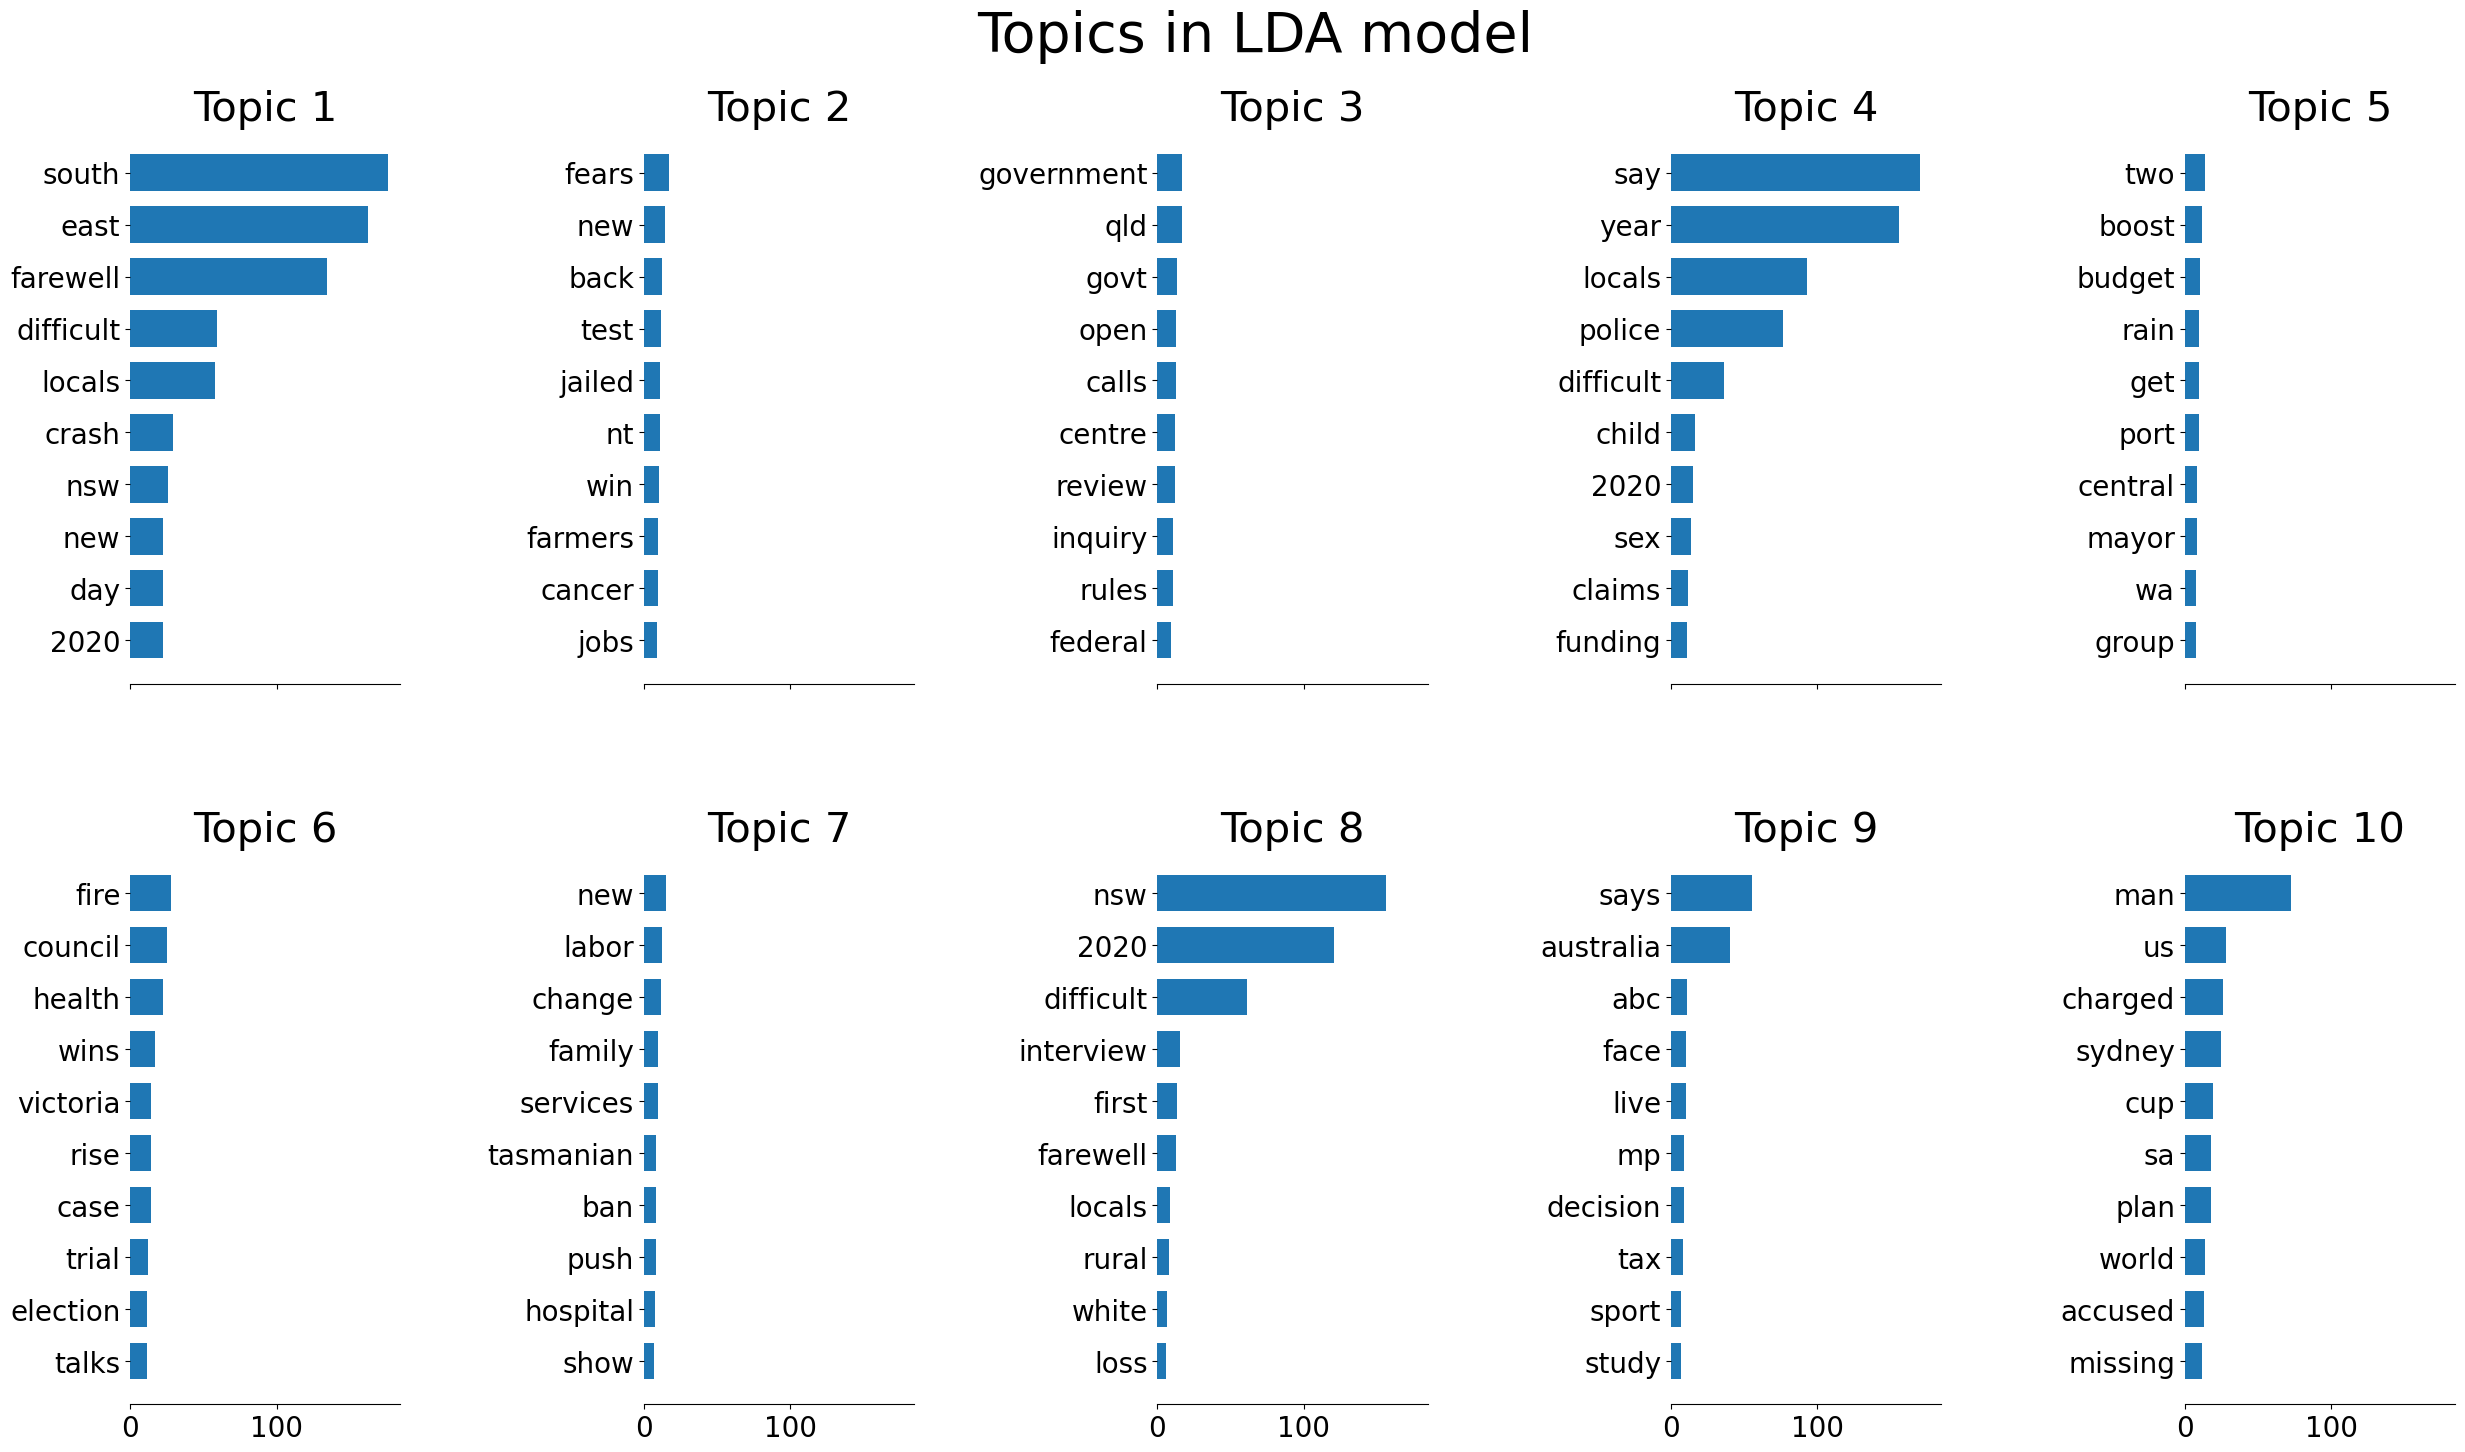

In [35]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(bow_reduced)
print("done in %0.3fs." % (time() - t0))

bow_feature_names = bow_vectorizer.get_feature_names_out()
plot_top_words(lda, bow_feature_names, 10 , "Topics in LDA model")

done in 1.140s.


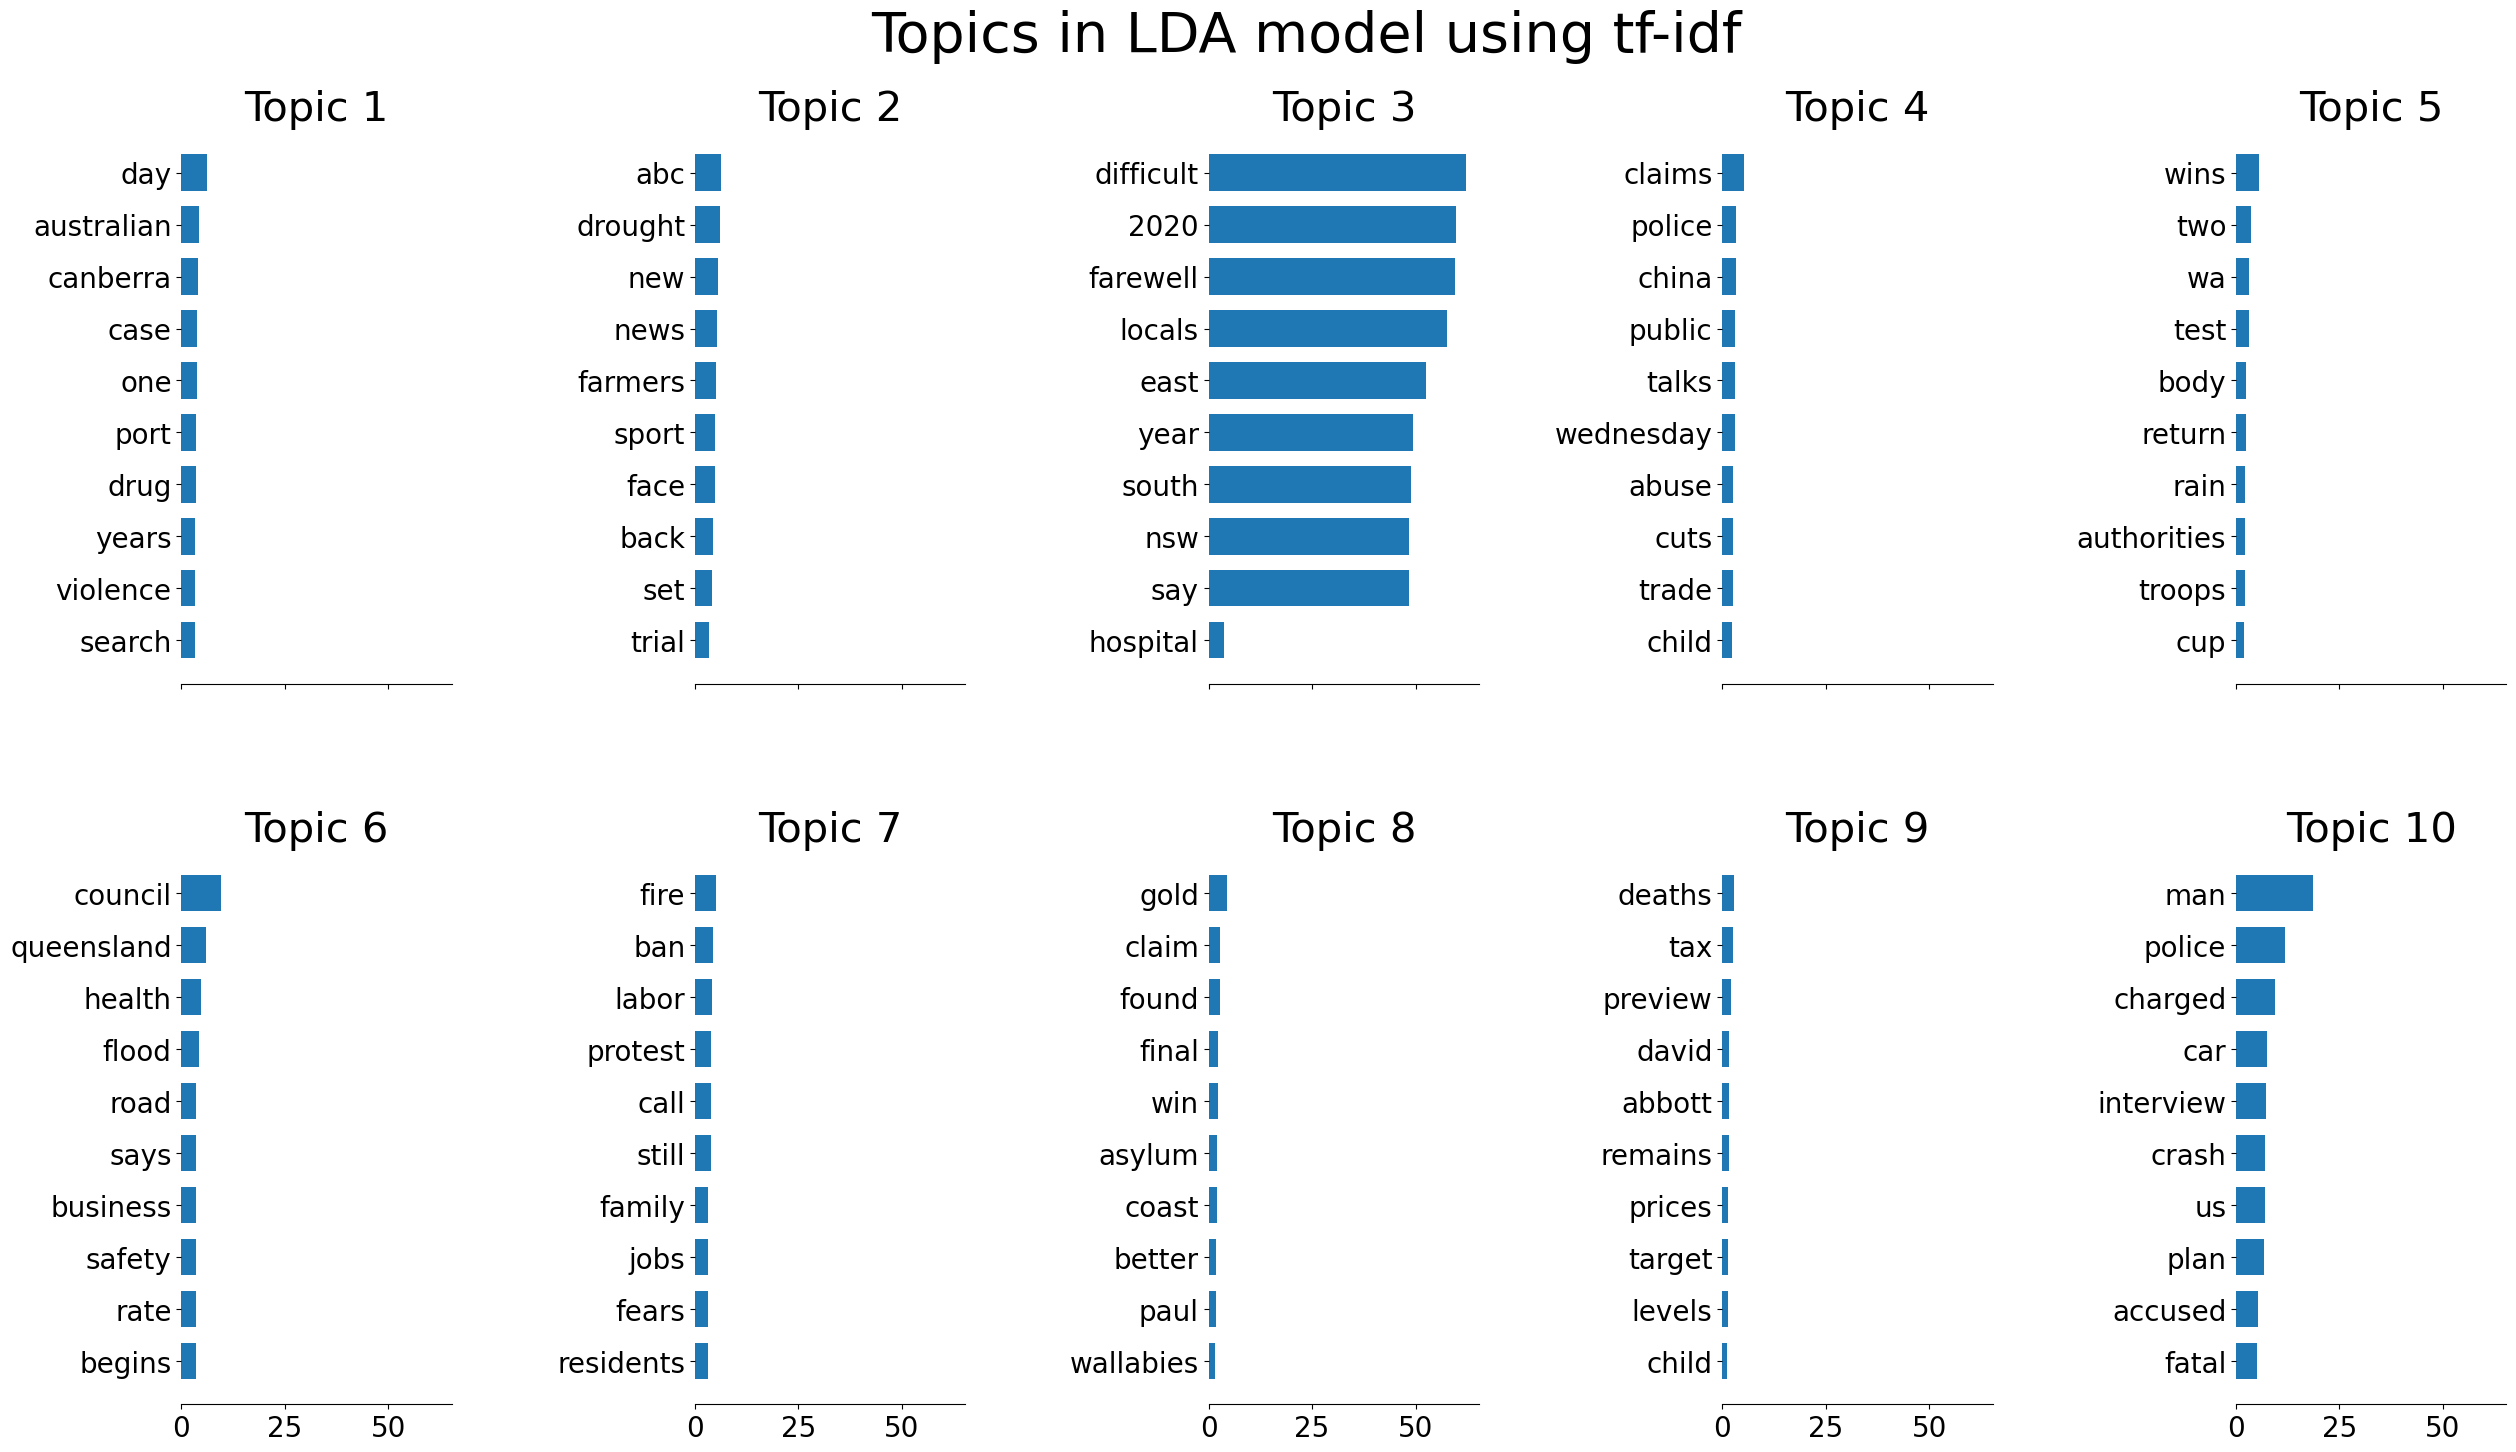

In [36]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tfidf_reduced)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(lda, tfidf_feature_names, 10 , "Topics in LDA model using tf-idf")

In [54]:
def ldaModel(n_components, max_iter, learning_method, vector, features, title):
    lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=max_iter,
    learning_method=learning_method,
    learning_offset=50.0,
    random_state=0,
    )
    t0 = time()
    lda.fit(vector)
    print("done in %0.3fs." % (time() - t0))

    feature_names = features
    plot_top_words(lda, feature_names, 10 , "Topics in LDA model using {} {} {}".format(title, n_components, max_iter))

done in 4.215s.


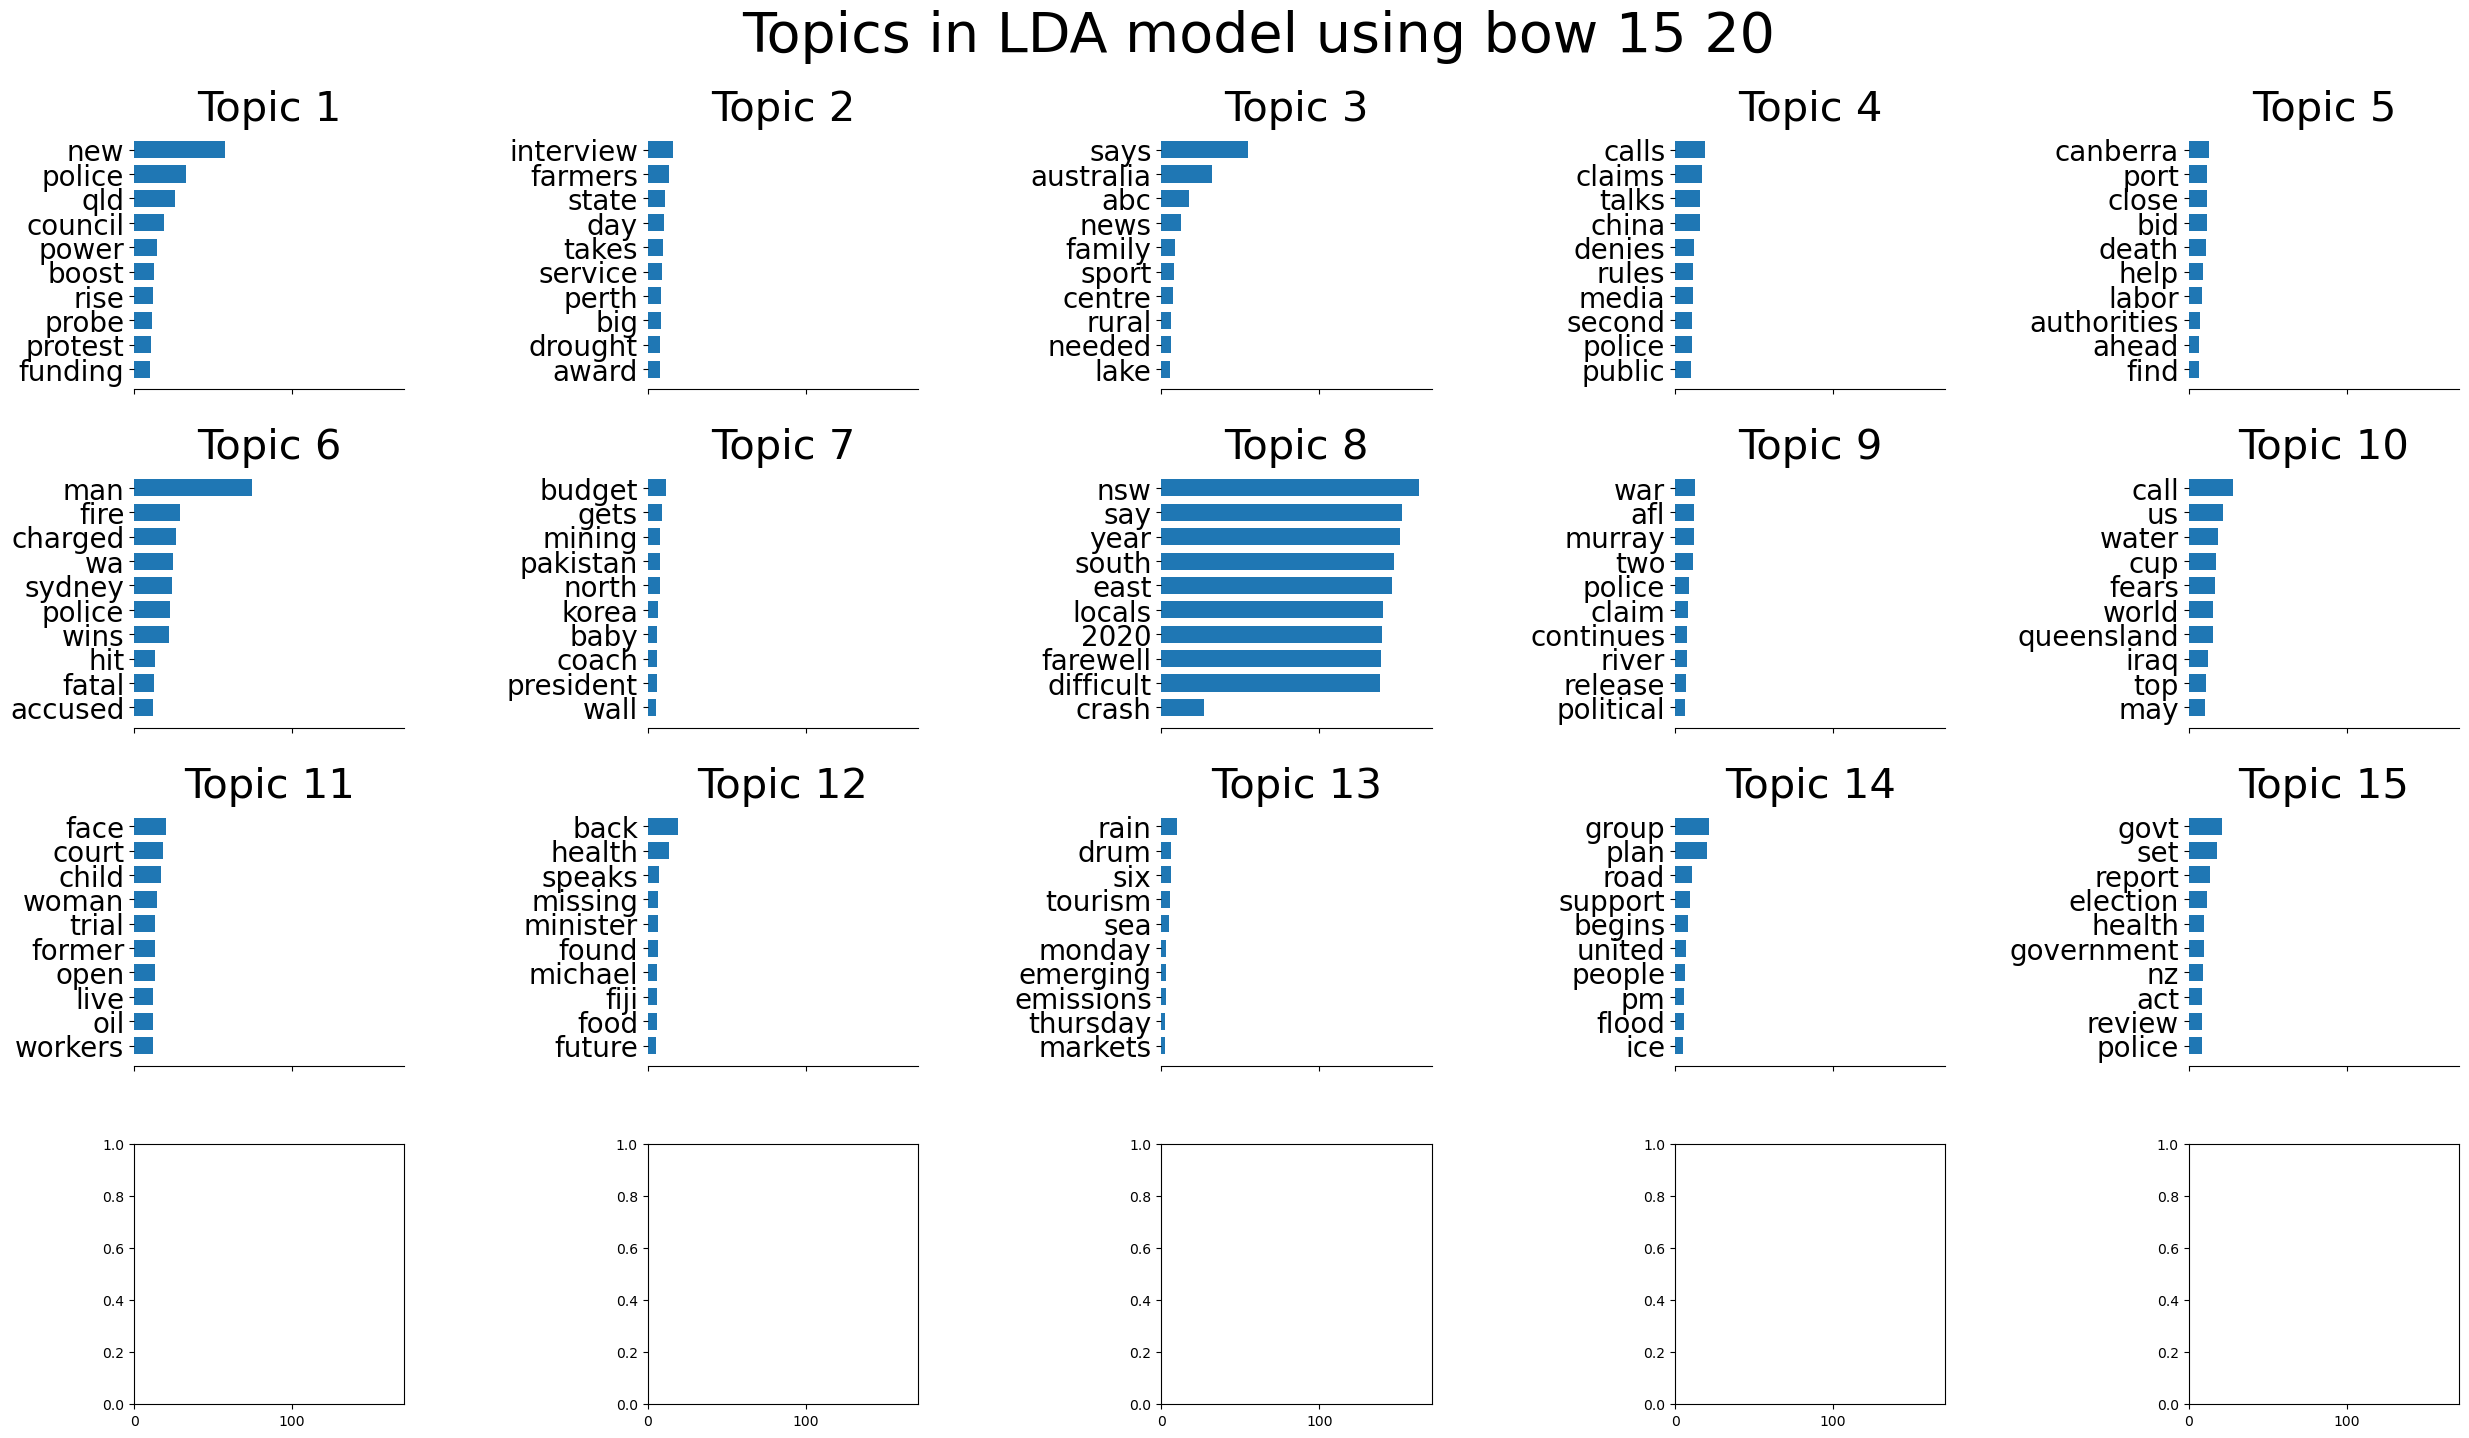

In [55]:
ldaModel(15, 20, 'online', bow_reduced, bow_vectorizer.get_feature_names_out(), 'bow')

done in 4.026s.


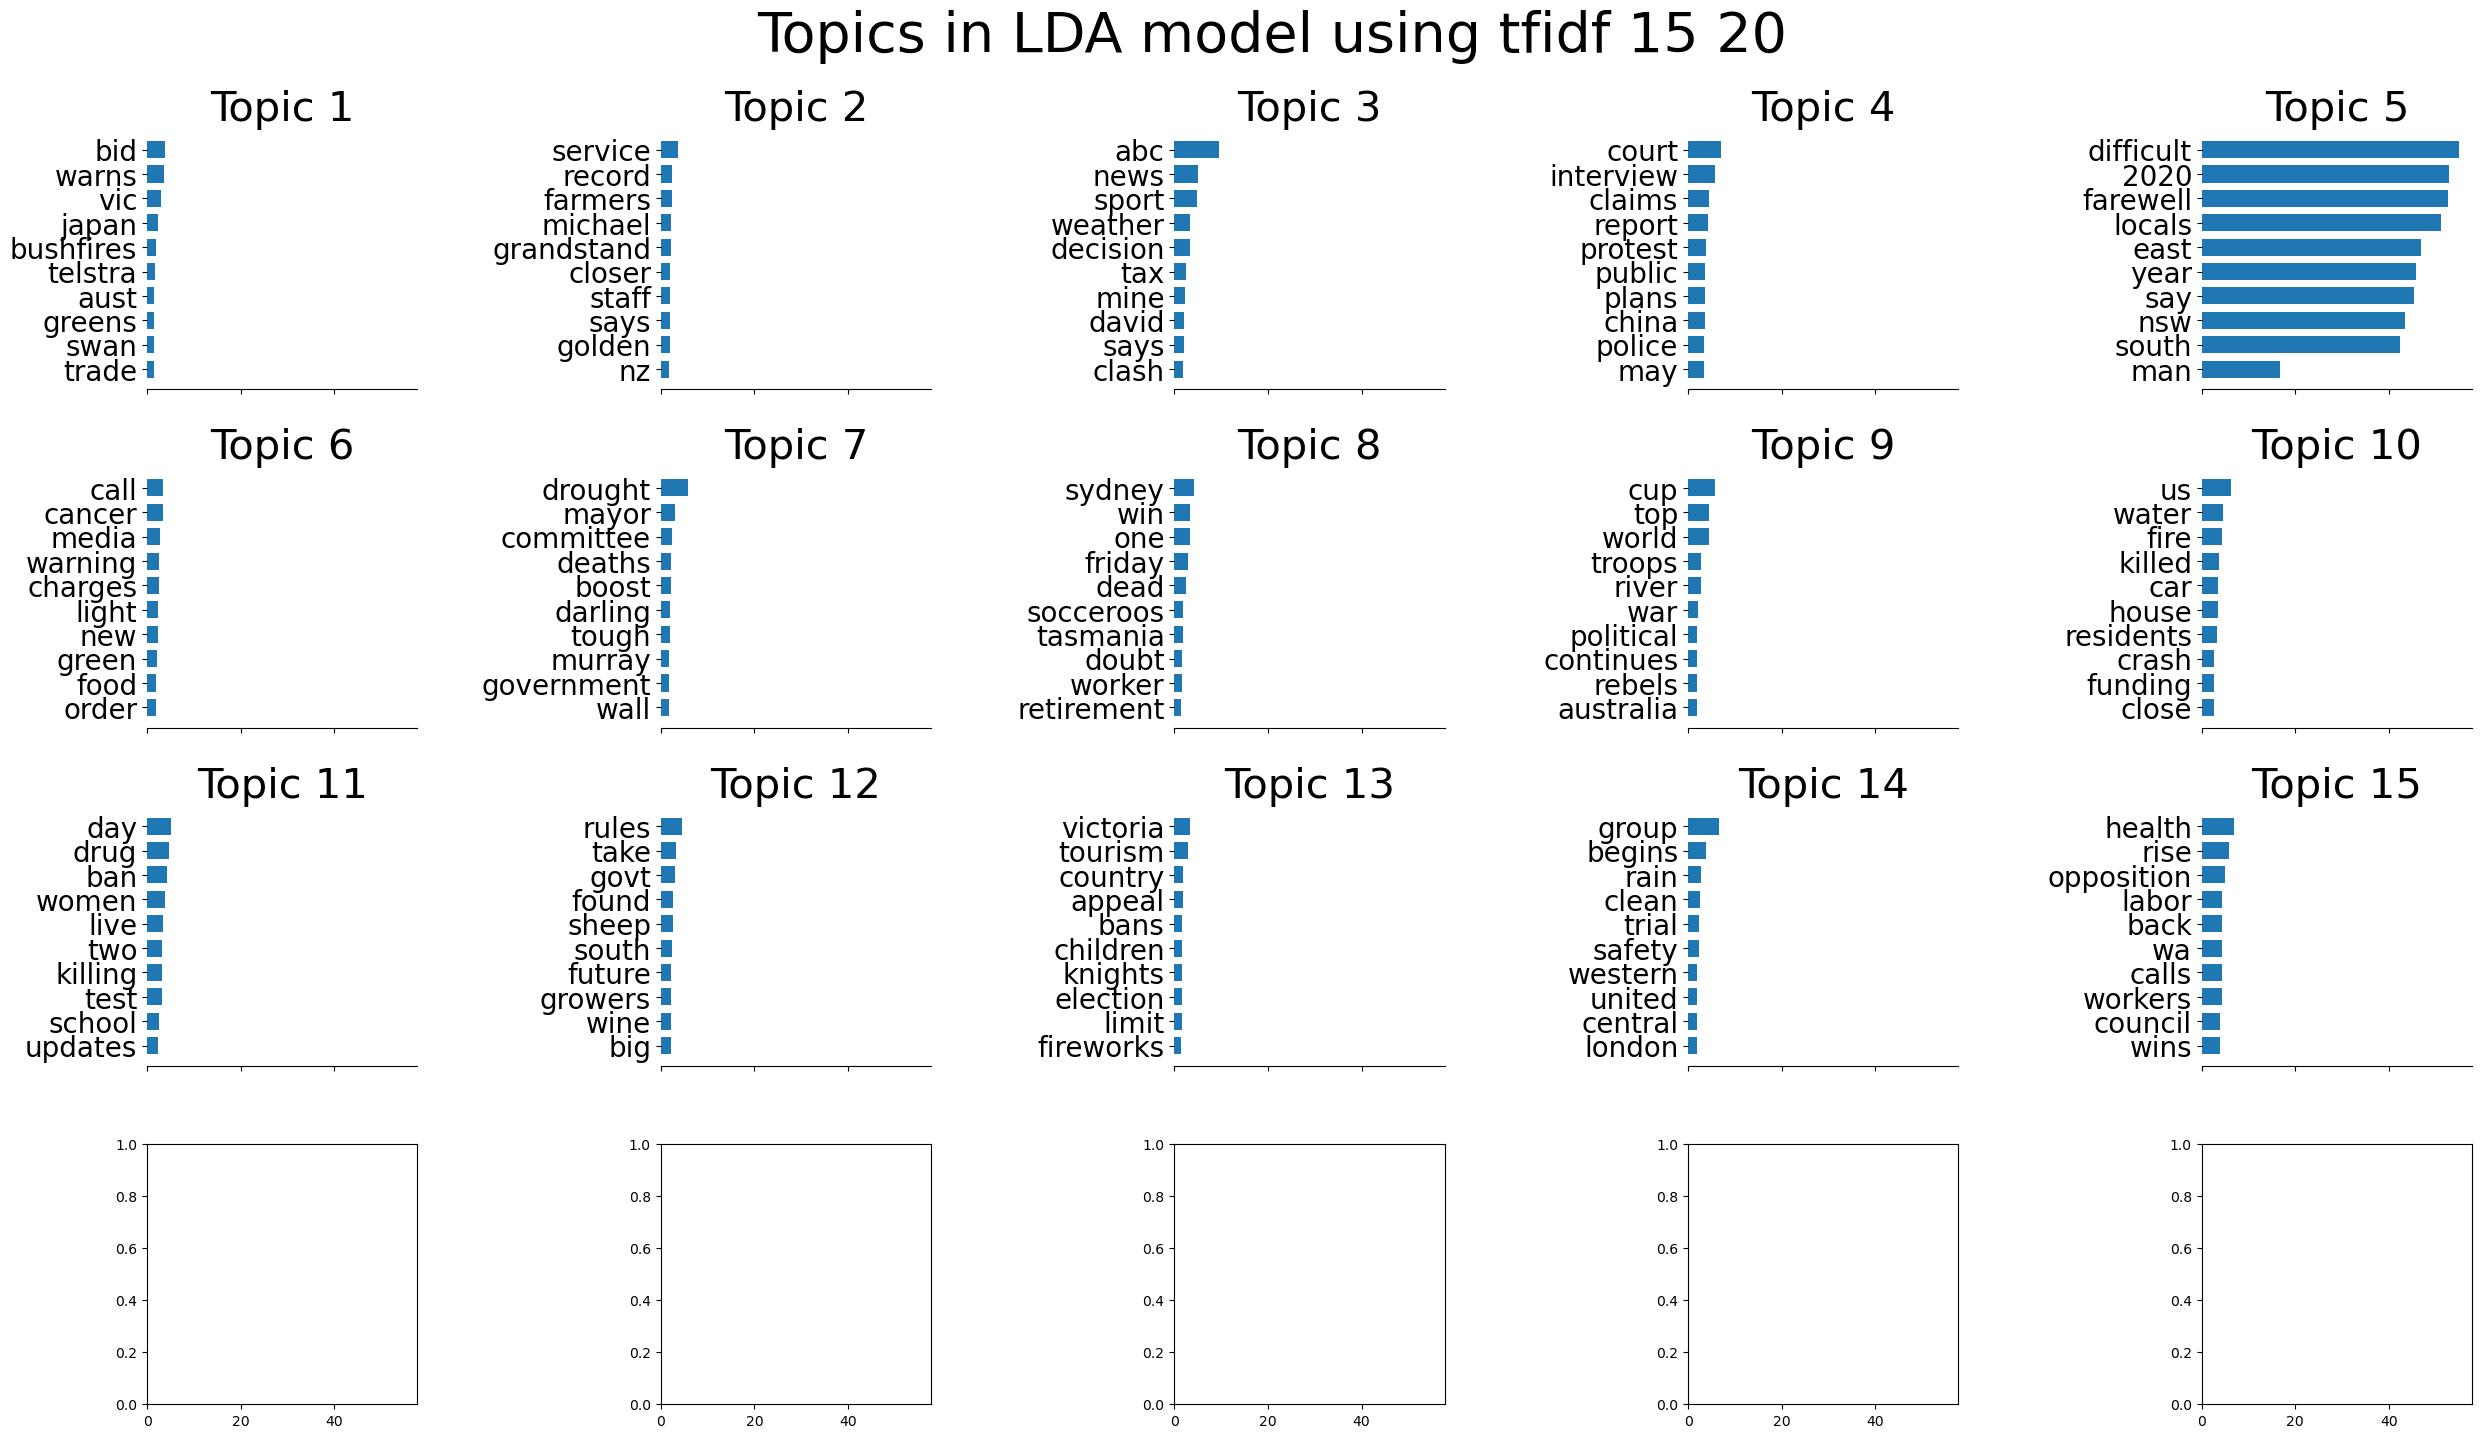

In [56]:
ldaModel(15, 20, 'online', tfidf_reduced, tfidf_vectorizer.get_feature_names_out(), 'tfidf')

done in 1.862s.


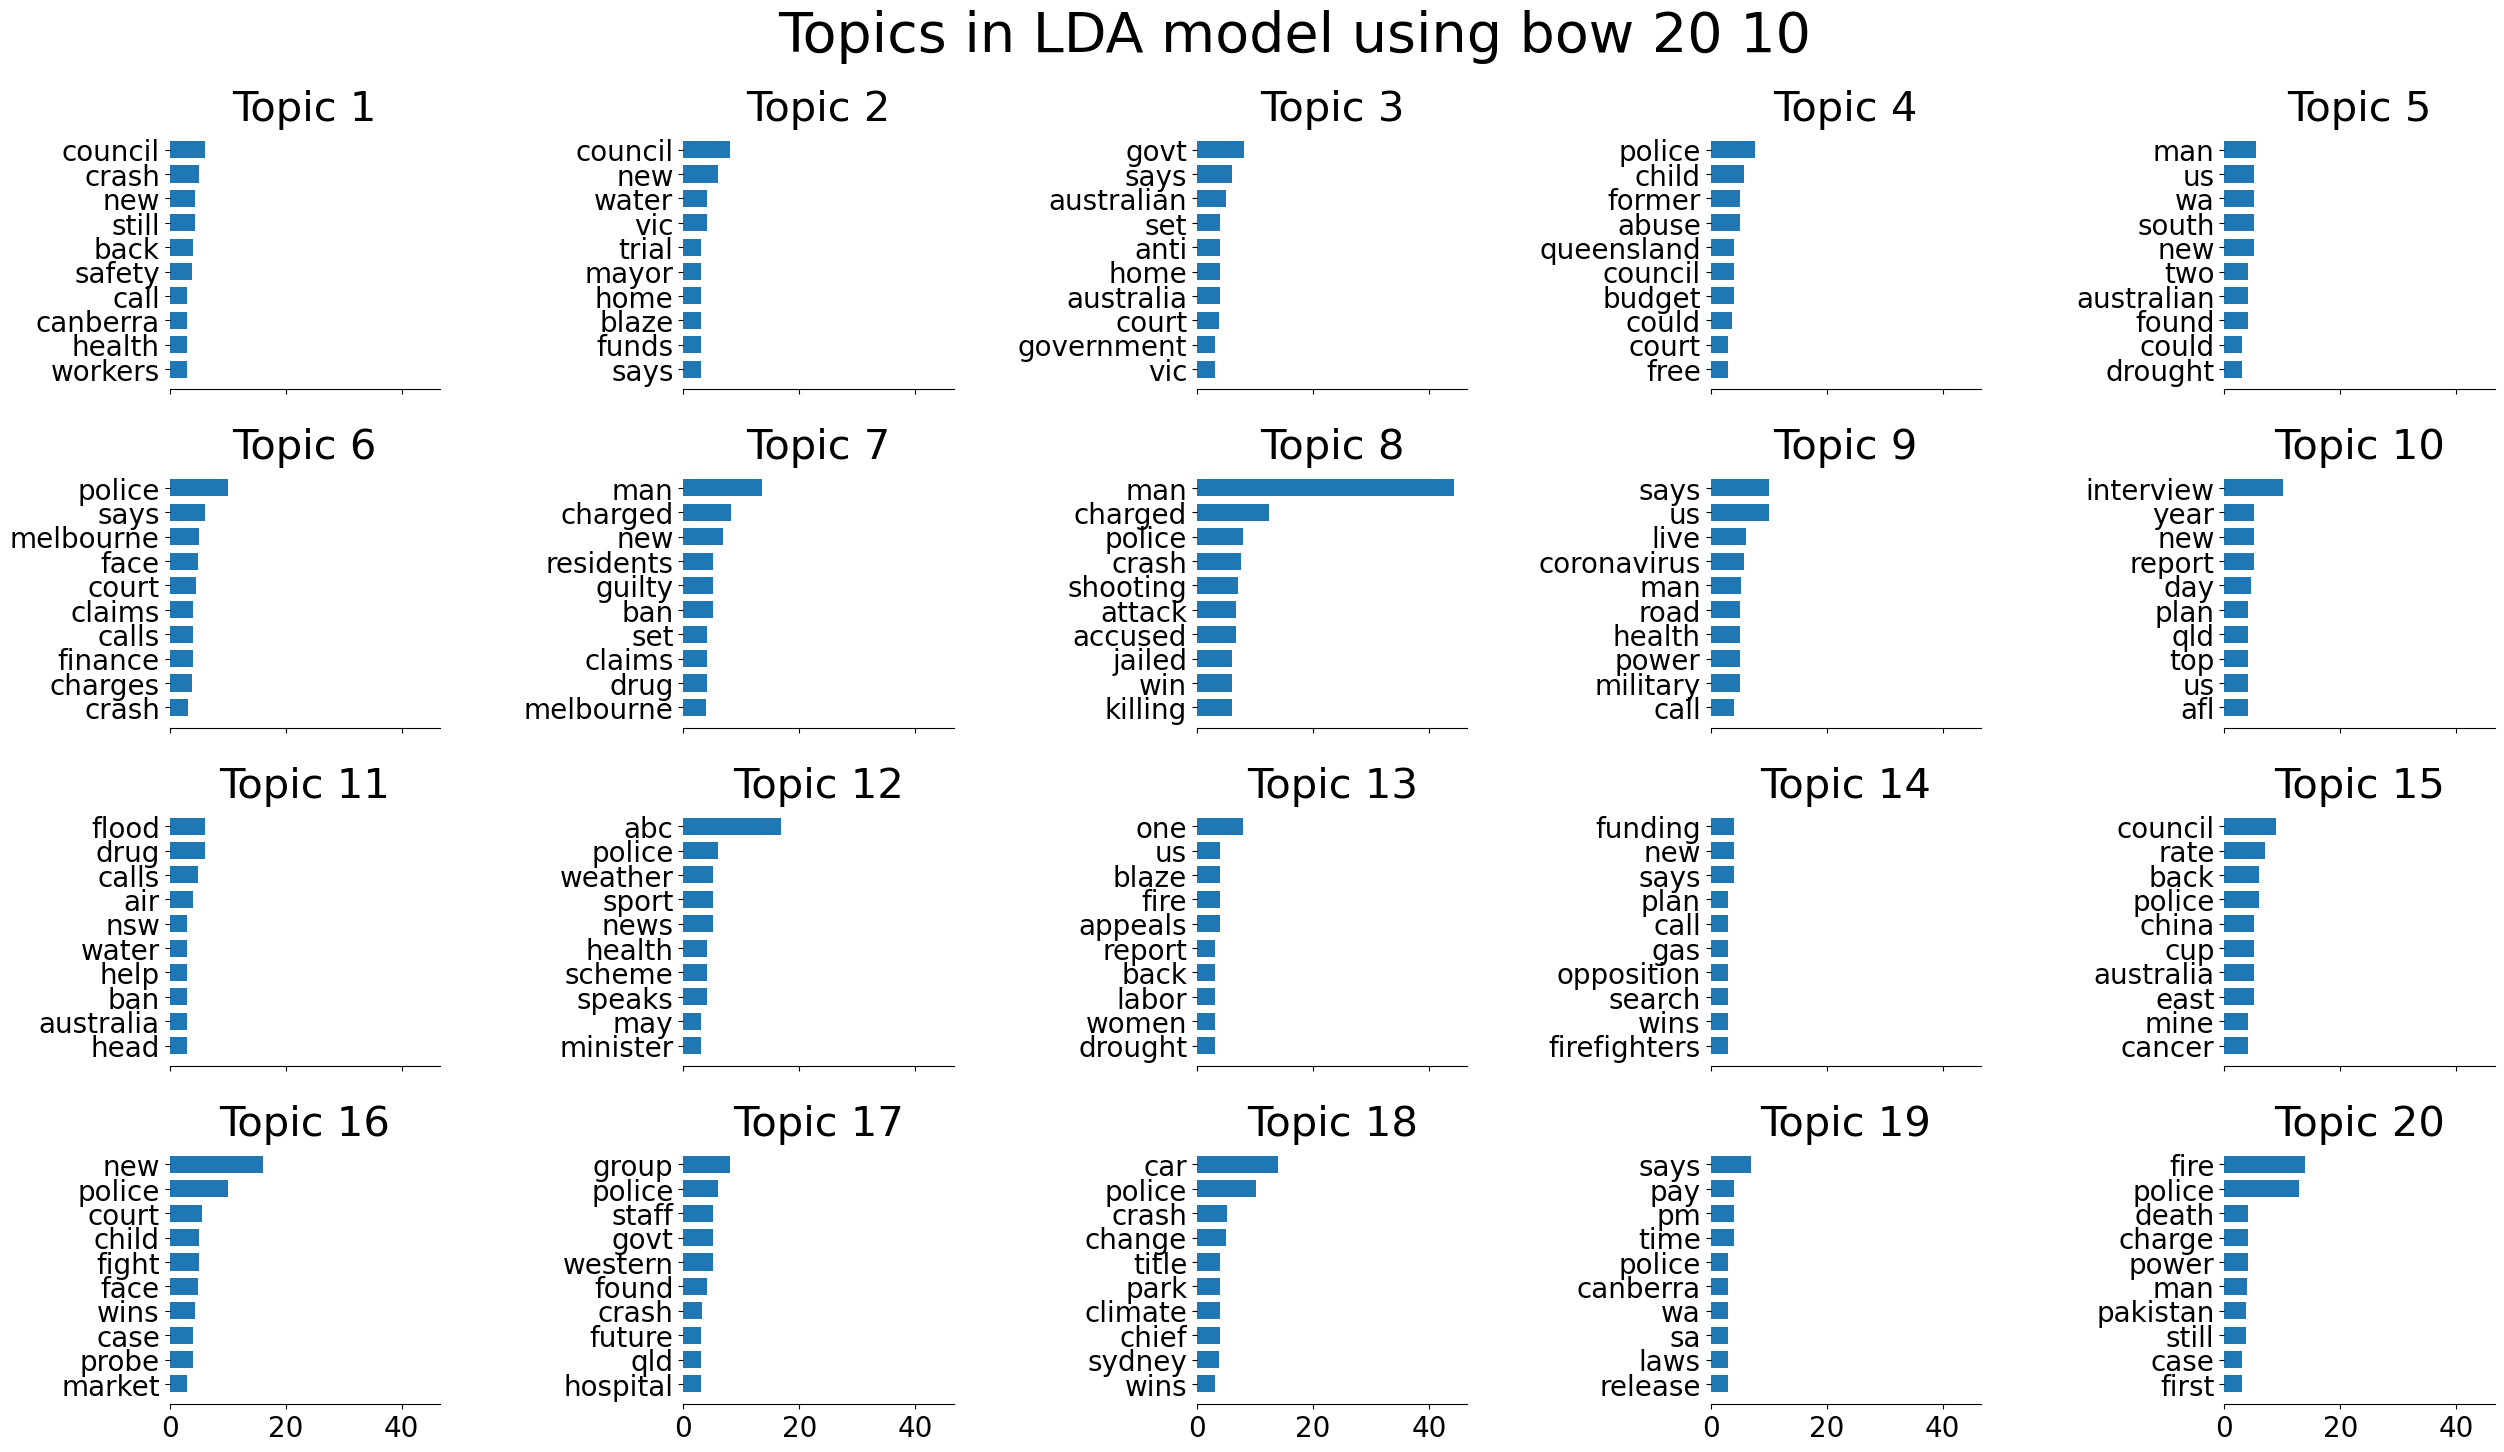

In [57]:
ldaModel(20, 10, 'batch', bow_reduced, bow_vectorizer.get_feature_names_out(), 'bow')

done in 1.616s.


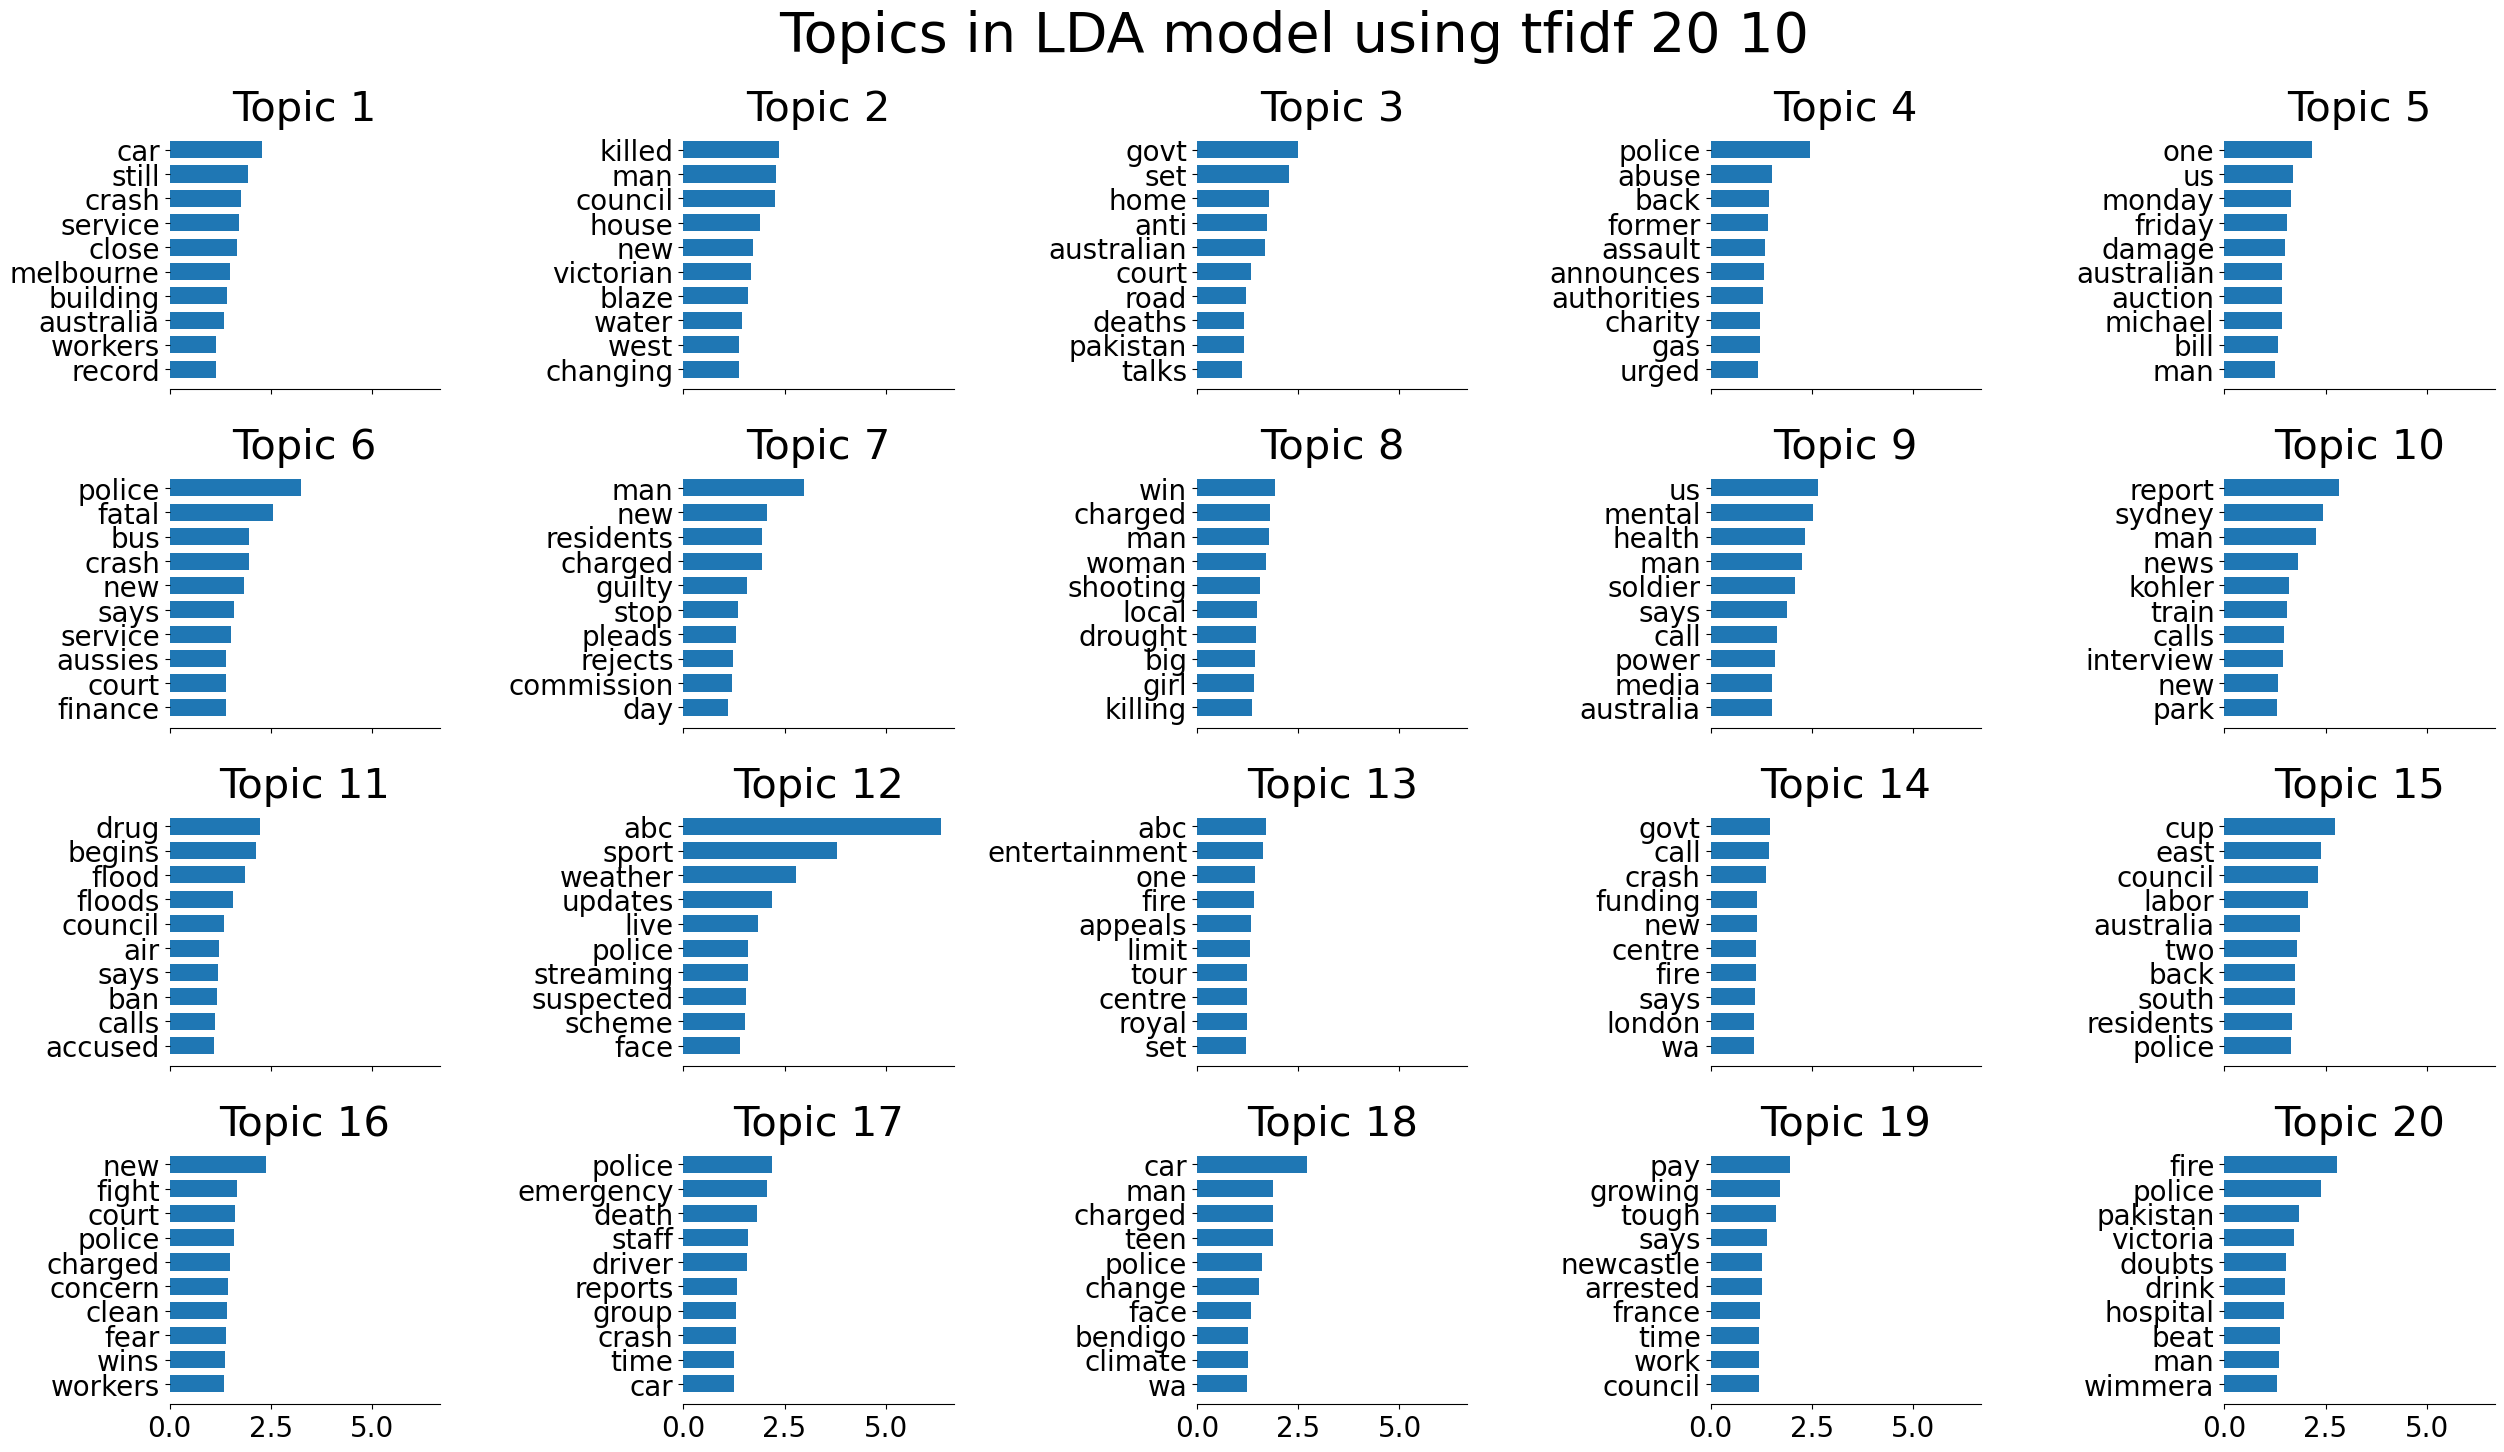

In [58]:
ldaModel(20, 10, 'batch', tfidf_reduced, tfidf_vectorizer.get_feature_names_out(), 'tfidf')